In [ ]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model,  load_model
from tensorflow.keras.layers import SimpleRNN, Dense


#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras import mixed_precision


#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
#from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras import mixed_precision

import matplotlib.pyplot as plt
import datetime

# 1. Daten abrufen

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365*2)  # 2 Jahre Historie

#df = yf.download(symbol, start=start_date, end=end_date)
#df = df[['close']].dropna()

# 1. Daten abrufen
folderPath_His = "/Users/Shared/ai_work/Trainingdata/ml_data/yh_his/D1/"
folderPath_models = "/Users/Shared/ai_work/Trainingdata/models/rnn/"
folderpath_results = "/Users/Shared/ai_work/Trainingdata/ml_results/rnn/"

#"/Users/workplacelivetv/Library/CloudStorage/GoogleDrive-robo01.rpa@gmail.com/My Drive/ml_data/yh_his/D1/"
#filepath = "/Users/workplacelivetv/Library/CloudStorage/GoogleDrive-robo01.rpa@gmail.com/My Drive/ml_data/yh_his/D1/QBTS.csv"
symbol = '#PLTR'
df = pd.read_csv (folderPath_His + symbol + ".csv")
#df = pd.read_csv (filepath)
# Daten laden
#df = yf.download("TSLA", start="2018-01-01", end=None)

lastBars = 0
n_tail = 200
n_pred_days = 60
n_time_steps = 60 # Neuronal Netzwerk
sequence_length = 60
n_epochs = 200 
n_batch_size = 16
df_his = df.tail(lastBars+1)
df_his["date"] = pd.to_datetime(df_his["date"]) 


df = df[['date','open', 'high', 'low', 'close','volume']]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df_full = df.copy()

#data = df.copy()
if n_tail > 0: df = df.tail(n_tail)
if lastBars > 0: df = df[: len(df)-lastBars]
df = df[['close']].dropna()



/tmp/ipykernel_334681/2105385316.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his["date"] = pd.to_datetime(df_his["date"])


In [ ]:

# 2. Daten skalieren
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
filePath_model =  folderPath_models +symbol+ ".keras"
model_name = filePath_model

# 3. Sequenzen vorbereiten
n_steps = 60
forecast_horizon = 7
from keras.saving import save_model
X, y = [], []
for i in range(n_steps, len(scaled_data) - forecast_horizon):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i:i + forecast_horizon].flatten())

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))
import os 

if os.path.exists(model_name) == False:

  # 4. RNN-Modell erstellen
  model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(n_steps, 1)),
    Dense(forecast_horizon)
   ])
  model.compile(optimizer='adam', loss='mean_squared_error')
  # 5. Modell trainieren
  model.fit(X, y, epochs=100, batch_size=32, verbose=1)
  save_model(model, model_name)


# --- Modell speichern ---



model_pred = load_model(model_name)
# 6. Vorhersage für die nächsten 7 Wochentage
last_sequence = scaled_data[-n_steps:]
last_sequence = last_sequence.reshape((1, n_steps, 1))
predicted_scaled = model.predict(last_sequence)
predicted_prices = scaler.inverse_transform(predicted_scaled)[0]


# 7. Nur Montag bis Freitag generieren
last_date = df.index[-1]
predicted_dates = []
day_offset = 1
while len(predicted_dates) < 7:
    next_date = last_date + datetime.timedelta(days=day_offset)
    if next_date.weekday() < 5:  # 0=Montag, ..., 4=Freitag
        predicted_dates.append(next_date)
    day_offset += 1





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


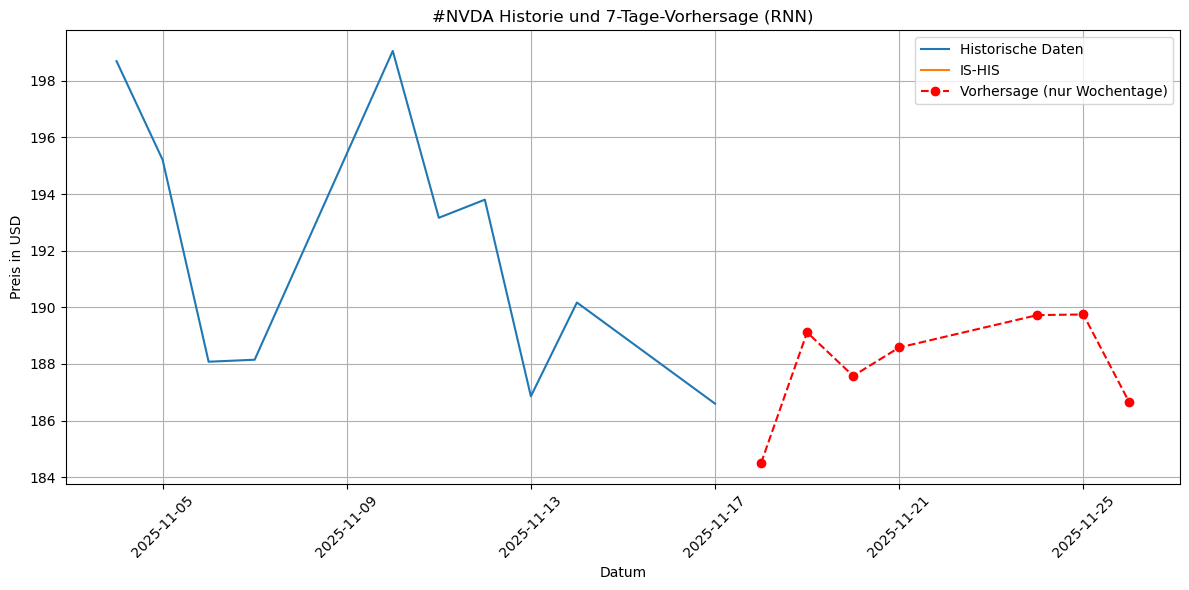

In [ ]:
# 8. Plot: Historische Daten + Vorhersage
df = df.tail(10)
df_his = df_his.set_index('date')
df_his = df_his.tail(lastBars)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='Historische Daten')
plt.plot(df_his.index, df_his['close'], label='IS-HIS')
plt.plot(predicted_dates, predicted_prices, marker='o', linestyle='--', color='red', label='Vorhersage (nur Wochentage)')
plt.title(symbol + ' Historie und 7-Tage-Vorhersage (RNN)')
plt.xlabel('Datum')
plt.ylabel('Preis in USD')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
predicted_dates

[Timestamp('2025-11-18 00:00:00'),
 Timestamp('2025-11-19 00:00:00'),
 Timestamp('2025-11-20 00:00:00'),
 Timestamp('2025-11-21 00:00:00'),
 Timestamp('2025-11-24 00:00:00'),
 Timestamp('2025-11-25 00:00:00'),
 Timestamp('2025-11-26 00:00:00')]

In [ ]:

# 8. DataFrame erstellen
last_close = df['close'].iloc[-1]
result_df = pd.DataFrame({
    'Symbol': [symbol]*7,
    'Type': ['TS']*7,
    'Date': predicted_dates,
    'Close': predicted_prices,
    'Source': [last_close]*7,
    'Change': [((pred - last_close) / last_close) * 100 for pred in predicted_prices]
})

# 9. Ausgabe
result_df.to_csv(folderpath_results+symbol +".csv")
